<a href="https://colab.research.google.com/github/bibekyess/AI_practice/blob/main/Killionaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os


In [2]:
# Gets the data
!wget https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single.csv

--2022-06-05 07:41:39--  https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50004 (49K) [text/plain]
Saving to: ‘daily_single.csv.1’

daily_single.csv.1  100%[===================>]  48.83K  --.-KB/s    in 0.008s  

2022-06-05 07:41:39 (6.25 MB/s) - ‘daily_single.csv.1’ saved [50004/50004]



In [3]:
"""
  Creates a bitcoin dataframe
"""
# Parse dates and set date column to index
df = pd.read_csv("/content/daily_single.csv", parse_dates=["Timestamp"])
df.rename(columns = {"Daily_Close": "Price"}, inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'].dt.date)
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(             Price
 Timestamp         
 2014-01-01  754.90
 2014-01-02  784.19
 2014-01-03  809.40
 2014-01-04  828.79
 2014-01-05  905.00,                Price
 Timestamp           
 2021-03-26  52734.30
 2021-03-27  54508.16
 2021-03-28  55871.93
 2021-03-29  57788.15
 2021-03-30  59069.29)

In [4]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2236 entries, 2014-01-01 to 2021-03-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2236 non-null   float64
dtypes: float64(1)
memory usage: 34.9 KB


In [5]:
# Displays the distribution of dataset
btc_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,2236.0,6692.873421,9291.712386,191.0,588.5375,4563.135,9107.615,60095.59


In [6]:
# Makes training, validation and test datasets
timesteps = btc_df.index.to_numpy()
prices = btc_df["Price"].to_numpy()

# 70% train, 15% validation, 15% test
boundary1 = int(0.7 * len(timesteps))
boundary2 = int(0.85 * len(timesteps))

X_train, Y_train = timesteps[:boundary1], prices[:boundary1]
X_val, Y_val = timesteps[boundary1:boundary2], prices[boundary1:boundary2]
X_test, Y_test = timesteps[boundary2:], prices[boundary2:]

len(X_train), len(X_val), len(X_test), len(Y_train), len(Y_val), len(Y_test)

(1565, 335, 336, 1565, 335, 336)

In [7]:
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None, xlabel='Timestamp', ylabel='Price'): 
  # for format, we can go with '.' or '-' [scatter or line] and start means offset
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

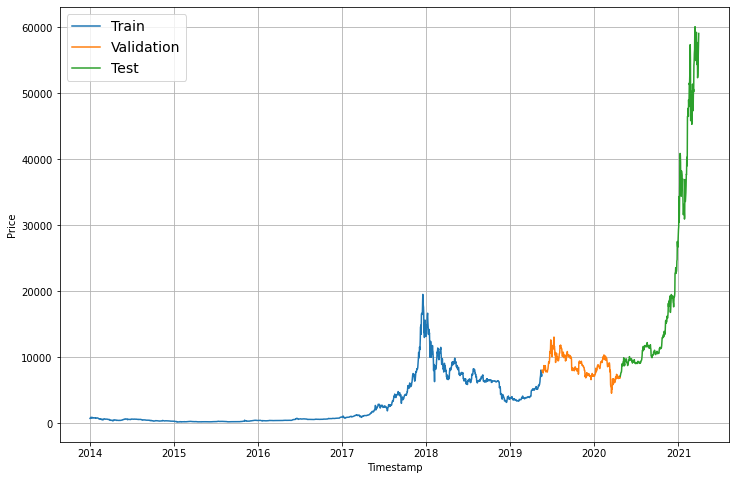

In [8]:
plt.figure(figsize=(12,8)) # Creates a figure and adds the following plot to it
plot_time_series(X_train, Y_train, label= "Train")
plot_time_series(X_val, Y_val, label= "Validation")
plot_time_series(X_test, Y_test, label = "Test")
# It would be interesting to put start and end as the year

Naive baseline model:
$\hat{y}_{t} = y_{t-1}$

In [9]:
naive_forecast = Y_test[:-1] # Gets every value excluding the last value

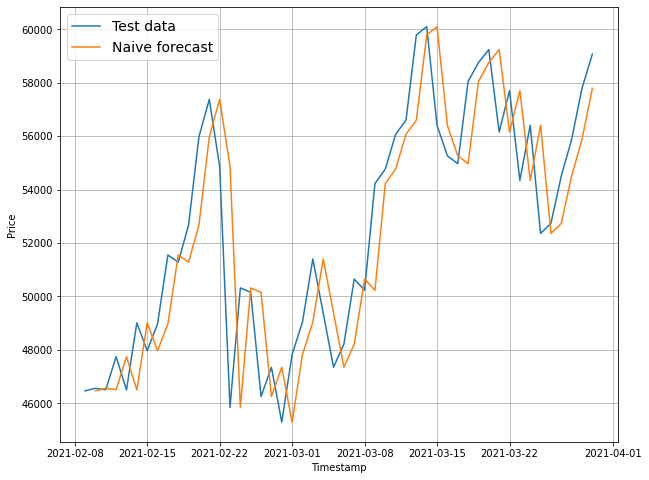

In [10]:
# Comparing naive_forecast with the test data
plt.figure(figsize=(10, 8))
offset = len(X_test)-50
plot_time_series(timesteps=X_test, values=Y_test, start = offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start = offset, format="-", label="Naive forecast");

In [11]:
"""
  returns error metrics in dictionary form
"""
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # better to use the numpy version of these too
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  return_dict =  {
                  "mae": mae.numpy(),
                  "mse": mse.numpy(),
                  "rmse": rmse.numpy(),
                  "mape": mape.numpy(),
                  }
  return return_dict


In [12]:
naive_results = evaluate_preds(y_true=Y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 685.7829, 'mape': 2.5663245, 'mse': 1749616.9, 'rmse': 1322.7308}

In [13]:
"""
  Windowing a dataset
  Using previous 7 days data to predict the price of 1 day
"""
WINDOW_SIZE = 7
HORIZON = 1

In [14]:
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [15]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    makes windows using numpy arrays' indexing
    returns 2D array of sequential windows of window size
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # -1 to prevent window going off the last value

    # Here window_indexes gives the position of the value of respective indexes, so using x[window_indexes] puts the respective x values in the position
    # specified in the window_indexes. It only works with numpy arrays
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
    return windows, labels


In [16]:
"""
  Makes training, validation and test datasets in windows
  70% train, 15% validation, 15% test
"""
boundary1 = int(0.85 * len(timesteps))
prices_test = prices[boundary1:]
prices_train_temp = prices[:boundary1]
mean = prices_train_temp.mean()
sd = prices_train_temp.std()
prices_train_temp = (prices_train_temp-mean)/sd
val_split = (0.85-0.7)/0.85
boundary2 = int((1-val_split) * len(prices_train_temp))
prices_train = prices_train_temp[:boundary2]
prices_val = prices_train_temp[boundary2:]

len(prices_train), len(prices_val), len(prices_test)

(1564, 336, 336)

In [17]:
train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
val_windows, val_labels = make_windows(prices_val, WINDOW_SIZE, HORIZON)
test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )
len(train_windows), len(val_windows), len(test_windows)

(1557, 329, 329)

In [18]:
"""
  Since we are comparing different model's performance, it is better to compare each model's best performance with another model's best
  Model's performance is going to fluctuate epoch to epoch
  Create a function to implement a ModelCheckpoint callback with a specific filename 
"""

def create_model_checkpoint(model_name, save_path="models"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0, # elsewise continously printout if saved or not
                                            save_best_only=True)

In [19]:
def early_stopping(): 
  return tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=40,
                                          restore_best_weights=True)

## Finetuning the hyperparameters
First, with a simple dense model, lets try to find out a good value for WINDOW_SIZE and batch_size

In [27]:
# for i in range(1, 31):
#   WINDOW_SIZE = i

#   # Make windowed data with appropriate horizon and window sizes
#   train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
#   val_windows, val_labels = make_windows(prices_val, WINDOW_SIZE, HORIZON)

#   tf.random.set_seed(42)
#   model_2 = tf.keras.Sequential([
#       layers.Dense(128, activation="relu"),
#       layers.Dense(HORIZON, activation="relu")
#   ], name="fine_tuning_window_"+str(i))

#   model_2.compile(loss='mae',
#                   optimizer=tf.keras.optimizers.Adam())

#   model_2.fit(train_windows,
#               train_labels,
#               epochs=100,
#               batch_size=128,
#               verbose=0,
#               validation_data=(val_windows, val_labels),
#               callbacks=[create_model_checkpoint(model_name=model_2.name)])


INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_2/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_2/assets
INFO:tensorflow:Asse

In [29]:
# min_loss = -1
# WINDOW_SIZE_N = 1
# for i in range(1, 31):
#   WINDOW_SIZE = i
#   test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )
#   model = tf.keras.models.load_model("models/fine_tuning_window_" + str(i))
#   loss = model.evaluate(test_windows, test_labels)
#   if (min_loss>loss): 
#     min_loss=loss
#     WINDOW_SIZE_N = i
#   elif (min_loss == -1): 
#     min_loss = loss
#     WINDOW_SIZE_N = i
# model_name = "models/fine_tuning_window_" + str(WINDOW_SIZE_N))
# WINDOW_SIZE = WINDOW_SIZE_N
# model_name, min_loss

10/10 [==============================] - 0s 2ms/step - loss: 1059.4702


('models/fine_tuning_window_30', 727.719482421875)

In [20]:
WINDOW_SIZE = 7

In [21]:
train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
val_windows, val_labels = make_windows(prices_val, WINDOW_SIZE, HORIZON)
test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )

**For batch_size**

In [33]:
# # Make windowed data with appropriate horizon and window sizes

# batch_sizes = [32, 64, 128, 256, 512, 1024]

# for i in batch_sizes:
#   tf.random.set_seed(42)
#   model_tuning = tf.keras.Sequential([
#       layers.Dense(128, activation="relu"),
#       layers.Dense(HORIZON, activation="relu")
#   ], name="fine_tuning_batch_size_"+str(i))

#   model_tuning.compile(loss='mae',
#                   optimizer=tf.keras.optimizers.Adam())

#   model_tuning.fit(train_windows,
#               train_labels,
#               epochs=100,
#               batch_size=i,
#               verbose=0,
#               validation_data=(val_windows, val_labels),
#               callbacks=[create_model_checkpoint(model_name=model_tuning.name)])


INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets wr

In [36]:
# min_loss = -1
# BATCH_SIZE = 0
# for i in batch_sizes:
#   model = tf.keras.models.load_model("models/fine_tuning_batch_size_" + str(i))
#   loss = model.evaluate(test_windows, test_labels)
#   if (min_loss>loss): 
#     min_loss=loss
#     BATCH_SIZE = i  
#   elif (min_loss == -1): 
#     min_loss=loss
#     BATCH_SIZE = i  

# model_name = "models/fine_tuning_batch_size_" + str(BATCH_SIZE)

# model_name, min_loss

11/11 [==============================] - 0s 2ms/step - loss: 875.9003


('models/fine_tuning_batch_size_512', 709.0518798828125)

In [22]:
BATCH_SIZE = 512

In [23]:
print("Window size is: ", WINDOW_SIZE)
print("Batch size is: ", BATCH_SIZE)

Window size is:  7
Batch size is:  512


In [24]:
""" 
  Model-1: Dense model (window=7, horizon=1)
"""

# Set random seed for as reprodicible results as possible
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation='relu')
], name='model_dense') # we can use it for our checkpoint function

# 2. Compile
model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=1000,
            verbose=1, # it refers to how much information we want to print for our models
            batch_size=BATCH_SIZE,
            validation_data=(val_windows, val_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name), early_stopping()])



Epoch 1/1000
4/4 [==============================] - 3s 226ms/step - loss: 1.0550 - mae: 1.0550 - mse: 1.4783 - val_loss: 0.4230 - val_mae: 0.4230 - val_mse: 0.2120
Epoch 2/1000
4/4 [==============================] - 0s 145ms/step - loss: 0.8212 - mae: 0.8212 - mse: 0.9484 - val_loss: 0.1626 - val_mae: 0.1626 - val_mse: 0.0427
Epoch 3/1000
4/4 [==============================] - 1s 194ms/step - loss: 0.6189 - mae: 0.6189 - mse: 0.5688 - val_loss: 0.1441 - val_mae: 0.1441 - val_mse: 0.0355
Epoch 4/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.5811 - mae: 0.5811 - mse: 0.4864 - val_loss: 0.1939 - val_mae: 0.1939 - val_mse: 0.0567
Epoch 5/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5862 - mae: 0.5862 - mse: 0.4895 - val_loss: 0.1544 - val_mae: 0.1544 - val_mse: 0.0396
Epoch 6/1000
4/4 [==============================] - 0s 148ms/step - loss: 0.5765 - mae: 0.5765 - mse: 0.4839 - val_loss: 0.1040 - val_mae: 0.1040 - val_mse: 0.0228
Epoch 7/1000
4/4 [

In [25]:
# Evaluates on test data
model_1 = tf.keras.models.load_model("models/model_dense")
model_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 3ms/step - loss: 711.6450 - mae: 711.6450 - mse: 1832902.7500


[711.64501953125, 711.64501953125, 1832902.75]

In [26]:
## After evaluating the model, lets forecast using the model (it is pseudo forecast)
def make_prediction(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # Squeezing is needed because we are returning 1D array of predictions

In [27]:
# Make predictions using model_dense on the test dataset and evaluate it on test data
model_1_prediction = make_prediction(model_1, test_windows)

In [28]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_prediction)
model_1_results

{'mae': 711.645, 'mape': 2.6642923, 'mse': 1832902.8, 'rmse': 1353.8474}

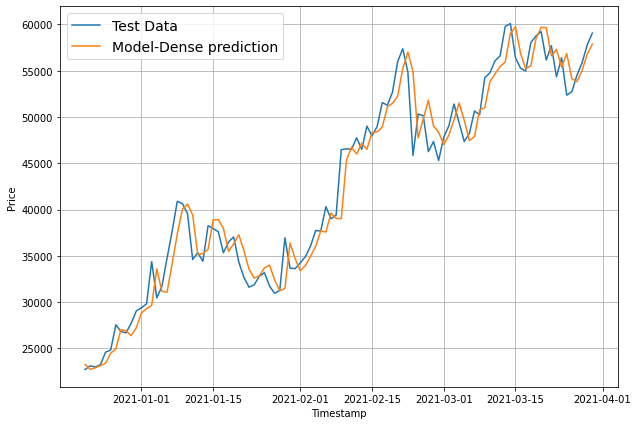

In [29]:
# Plotting model-1 predictions
plt.figure(figsize=(10,7))
offset=len(test_windows)-100
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='Test Data', format="-")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_prediction, start=offset, label="Model-Dense prediction", format='-')

### Model-2 CNN

In [30]:
tf.random.set_seed(42)

# Create Conv1D model
model_2 = tf.keras.Sequential([

  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  
  layers.Conv1D(filters=256, kernel_size=8, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  layers.GlobalAveragePooling1D(),
  layers.Dense(HORIZON, activation="relu")

], name="model_conv1D")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_2.fit(train_windows, #if faced data cardinality error, do tf.stack(train_windows) or np.array(train_windows)
            train_labels, 
            batch_size=BATCH_SIZE, 
            epochs=1000, 
            verbose=1,
            validation_data=(val_windows, val_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name), early_stopping()]
            )

Epoch 1/1000
4/4 [==============================] - 10s 608ms/step - loss: 0.7545 - val_loss: 0.5484
Epoch 2/1000
4/4 [==============================] - 1s 252ms/step - loss: 0.6407 - val_loss: 0.1705
Epoch 3/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5760 - val_loss: 0.1895
Epoch 4/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5917 - val_loss: 0.2199
Epoch 5/1000
4/4 [==============================] - 1s 178ms/step - loss: 0.5901 - val_loss: 0.1288
Epoch 6/1000
4/4 [==============================] - 1s 184ms/step - loss: 0.5728 - val_loss: 0.1145
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5716 - val_loss: 0.1270
Epoch 8/1000
4/4 [==============================] - 1s 178ms/step - loss: 0.5712 - val_loss: 0.1007
Epoch 9/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5686 - val_loss: 0.1135
Epoch 10/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5715 - val_loss: 0.1120
Epo

In [31]:
model_2 = tf.keras.models.load_model("models/model_conv1D")
model_2.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 4ms/step - loss: 739.7759


739.7759399414062

In [32]:
# Model predictions
model_2_preds = make_prediction(model_2, test_windows)

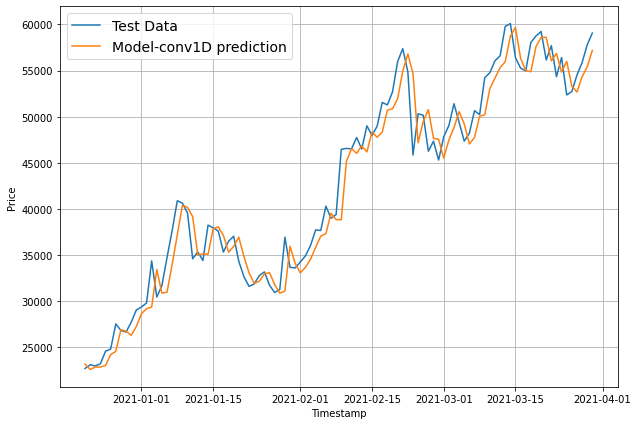

In [33]:
offset=len(test_windows)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, format="-", start=offset, label="Model-conv1D prediction")

In [34]:
# Evaluate predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 739.77594, 'mape': 2.758292, 'mse': 1877335.4, 'rmse': 1370.1588}

# Model 3: RNN (LSTM)

In [35]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x) # to create more than 1 hidden layer
x = layers.Bidirectional(layers.LSTM(128, activation="relu"))(x)
# x = layers.LSTM(128, activation="relu")(x)
# One of the way of improving the accuracy of neural network is adding more layers
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(val_windows, val_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name), early_stopping()]
            )



Epoch 1/1000
1/4 [======>.......................] - ETA: 5s - loss: 0.8119INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 7s 2s/step - loss: 0.7935 - val_loss: 1.0567
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.7163INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.7050 - val_loss: 0.9423
Epoch 3/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.6292INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.6143 - val_loss: 0.8031
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.5424INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.5090 - val_loss: 0.6354
Epoch 5/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.4254INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.3835 - val_loss: 0.4266
Epoch 6/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.2638INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.2308 - val_loss: 0.1771
Epoch 7/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.1048INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0845 - val_loss: 0.1436
Epoch 8/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1279 - val_loss: 0.1534
Epoch 9/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.1065INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0905 - val_loss: 0.1115
Epoch 10/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0725 - val_loss: 0.1230
Epoch 11/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0640 - val_loss: 0.1623
Epoch 12/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0675 - val_loss: 0.1579
Epoch 13/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0615 - val_loss: 0.1248
Epoch 14/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0502INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0528 - val_loss: 0.1028
Epoch 15/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0516INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0520 - val_loss: 0.1012
Epoch 16/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0522 - val_loss: 0.1067
Epoch 17/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0500 - val_loss: 0.1160
Epoch 18/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0491 - val_loss: 0.1082
Epoch 19/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0470INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0488 - val_loss: 0.1011
Epoch 20/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0485INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0477 - val_loss: 0.0952
Epoch 21/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0502INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0472 - val_loss: 0.0945
Epoch 22/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0457 - val_loss: 0.1075
Epoch 23/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0429INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0446 - val_loss: 0.0895
Epoch 24/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0393INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0451 - val_loss: 0.0855
Epoch 25/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0433 - val_loss: 0.0979
Epoch 26/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0422 - val_loss: 0.1001
Epoch 27/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0399INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0410 - val_loss: 0.0797
Epoch 28/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0402 - val_loss: 0.0839
Epoch 29/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0407 - val_loss: 0.0866
Epoch 30/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0393 - val_loss: 0.0751
Epoch 31/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0374INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0409 - val_loss: 0.0751
Epoch 32/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0375 - val_loss: 0.1117
Epoch 33/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0395INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0392 - val_loss: 0.0732
Epoch 34/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0369INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0392 - val_loss: 0.0720
Epoch 35/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0373 - val_loss: 0.0929
Epoch 36/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0392 - val_loss: 0.0723
Epoch 37/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0388 - val_loss: 0.0725
Epoch 38/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0366INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0382 - val_loss: 0.0707
Epoch 39/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0382 - val_loss: 0.0719
Epoch 40/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0402 - val_loss: 0.0719
Epoch 41/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0398INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0394 - val_loss: 0.0702
Epoch 42/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0376 - val_loss: 0.0794
Epoch 43/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0301INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0377 - val_loss: 0.0685
Epoch 44/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0384 - val_loss: 0.0695
Epoch 45/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0367 - val_loss: 0.0765
Epoch 46/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0384 - val_loss: 0.0884
Epoch 47/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0364INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0354 - val_loss: 0.0680
Epoch 48/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0349 - val_loss: 0.0734
Epoch 49/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0361 - val_loss: 0.0783
Epoch 50/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0372INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0347 - val_loss: 0.0675
Epoch 51/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0349 - val_loss: 0.0816
Epoch 52/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0352 - val_loss: 0.0694
Epoch 53/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0352INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0341 - val_loss: 0.0672
Epoch 54/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0334 - val_loss: 0.0727
Epoch 55/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0351INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0340 - val_loss: 0.0667
Epoch 56/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0337 - val_loss: 0.0834
Epoch 57/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0337INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0343 - val_loss: 0.0662
Epoch 58/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0334 - val_loss: 0.0668
Epoch 59/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0329 - val_loss: 0.0684
Epoch 60/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0329 - val_loss: 0.0782
Epoch 61/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0364 - val_loss: 0.0933
Epoch 62/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0334 - val_loss: 0.0672
Epoch 63/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0326 - val_loss: 0.0687
Epoch 64/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0326 - val_loss: 0.0695
Epoch 65/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0345INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0328 - val_loss: 0.0648
Epoch 66/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0300INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0328 - val_loss: 0.0646
Epoch 67/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0321 - val_loss: 0.0675
Epoch 68/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0326 - val_loss: 0.0745
Epoch 69/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0350 - val_loss: 0.0661
Epoch 70/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0351 - val_loss: 0.0841
Epoch 71/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0339 - val_loss: 0.0994
Epoch 72/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0417 - val_loss: 0.0698
Epoch 73/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0324 - val_loss: 0.0822
Epoch 74/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0346 - val_loss: 0.0885
Epoch 75/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0386 - val_loss: 0.0772
Epoch 76/1000
4/

INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0325 - val_loss: 0.0644
Epoch 82/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0313 - val_loss: 0.0730
Epoch 83/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0323 - val_loss: 0.0739
Epoch 84/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0330 - val_loss: 0.0816
Epoch 85/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0316 - val_loss: 0.0706
Epoch 86/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0335 - val_loss: 0.0727
Epoch 87/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0377 - val_loss: 0.0981
Epoch 88/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0344 - val_loss: 0.0953
Epoch 89/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0357 - val_loss: 0.0723
Epoch 90/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0352 - val_loss: 0.1059
Epoch 91/1000
4/

INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0348 - val_loss: 0.0641
Epoch 95/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0330 - val_loss: 0.0744
Epoch 96/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0356INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0333 - val_loss: 0.0640
Epoch 97/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0333 - val_loss: 0.0699
Epoch 98/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0350 - val_loss: 0.0739
Epoch 99/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0351 - val_loss: 0.0814
Epoch 100/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0352 - val_loss: 0.0667
Epoch 101/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0324 - val_loss: 0.0652
Epoch 102/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0319 - val_loss: 0.0714
Epoch 103/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0314 - val_loss: 0.0700
Epoch 104/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0347 - val_loss: 0.0658
Epoch 105/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0310 - val_loss: 0.0777
Epoch 106/

INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0310 - val_loss: 0.0630
Epoch 111/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0306 - val_loss: 0.0655
Epoch 112/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0296 - val_loss: 0.0711
Epoch 113/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0313 - val_loss: 0.0638
Epoch 114/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0296 - val_loss: 0.0659
Epoch 115/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0292 - val_loss: 0.0634
Epoch 116/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0291 - val_loss: 0.0653
Epoch 117/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0305 - val_loss: 0.0637
Epoch 118/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0308 - val_loss: 0.0714
Epoch 119/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0323 - val_loss: 0.0676
Epoch 1

INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0309 - val_loss: 0.0625
Epoch 124/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0294 - val_loss: 0.0683
Epoch 125/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0295 - val_loss: 0.0661
Epoch 126/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0311 - val_loss: 0.0691
Epoch 127/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0322 - val_loss: 0.0728
Epoch 128/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0318 - val_loss: 0.0651
Epoch 129/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0309 - val_loss: 0.0643
Epoch 130/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0305 - val_loss: 0.0637
Epoch 131/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0316 - val_loss: 0.0699
Epoch 132/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0331 - val_loss: 0.0631
Epoch 1

INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0288 - val_loss: 0.0624
Epoch 138/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0303INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0302 - val_loss: 0.0623
Epoch 139/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0288 - val_loss: 0.0632
Epoch 140/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0301 - val_loss: 0.0632
Epoch 141/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 0.0630
Epoch 142/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0290 - val_loss: 0.0629
Epoch 143/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0302 - val_loss: 0.0645
Epoch 144/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0304 - val_loss: 0.0741
Epoch 145/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0297 - val_loss: 0.0730
Epoch 146/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0305 - val_loss: 0.0647
Epoch 147/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0287 - val_loss: 0.0628
Epoch 1

INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0313 - val_loss: 0.0622
Epoch 154/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0325 - val_loss: 0.0837
Epoch 155/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0314 - val_loss: 0.0797
Epoch 156/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0358 - val_loss: 0.0634
Epoch 157/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0316 - val_loss: 0.0908
Epoch 158/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0329 - val_loss: 0.0794
Epoch 159/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0331 - val_loss: 0.0625
Epoch 160/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0299 - val_loss: 0.0883
Epoch 161/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0322 - val_loss: 0.0649
Epoch 162/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0297 - val_loss: 0.0623
Epoch 1

INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0306 - val_loss: 0.0620
Epoch 170/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0306 - val_loss: 0.0623
Epoch 171/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0258INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0295 - val_loss: 0.0618
Epoch 172/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0280 - val_loss: 0.0619
Epoch 173/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0283 - val_loss: 0.0630
Epoch 174/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0297 - val_loss: 0.0619
Epoch 175/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0293 - val_loss: 0.0651
Epoch 176/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0295 - val_loss: 0.0661
Epoch 177/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0293 - val_loss: 0.0638
Epoch 178/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0286 - val_loss: 0.0871
Epoch 179/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0340 - val_loss: 0.0670
Epoch 180/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0295 - val_loss: 0.0799
Epoch 1

INFO:tensorflow:Assets written to: models/model_lstm/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0343 - val_loss: 0.0616
Epoch 201/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0291 - val_loss: 0.0758
Epoch 202/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0306 - val_loss: 0.0659
Epoch 203/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0289 - val_loss: 0.0626
Epoch 204/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0282 - val_loss: 0.0647
Epoch 205/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0289 - val_loss: 0.0648
Epoch 206/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0293 - val_loss: 0.0728
Epoch 207/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0296 - val_loss: 0.0647
Epoch 208/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0299 - val_loss: 0.0688
Epoch 209/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0291 - val_loss: 0.0700
Epoch 2

In [36]:
model_3 = tf.keras.models.load_model("models/model_lstm")
model_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 3ms/step - loss: 7211.0547


7211.0546875

In [37]:
# Make predictions with our LSTM model
model_3_preds = make_prediction(model_3, test_windows)


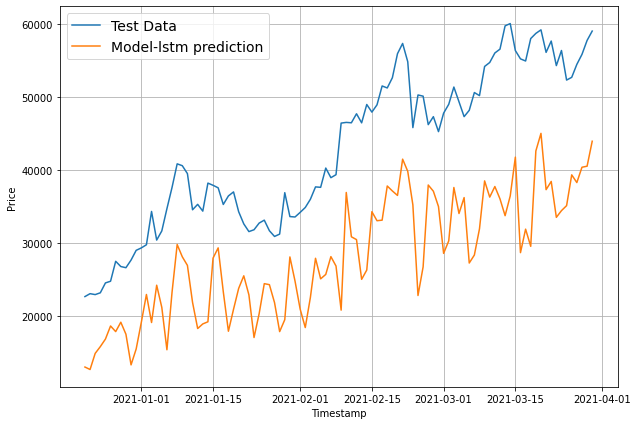

In [38]:
offset=len(test_windows)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, format="-", start=offset, label="Model-lstm prediction")

In [39]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': 7211.0547, 'mape': 33.133076, 'mse': 86421220.0, 'rmse': 9296.301}

## Multivariate Models

In [40]:
!wget https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_multi.csv

--2022-06-05 07:47:20--  https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_multi.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150707 (147K) [text/plain]
Saving to: ‘daily_multi.csv.1’

daily_multi.csv.1   100%[===================>] 147.17K  --.-KB/s    in 0.01s   

2022-06-05 07:47:20 (9.62 MB/s) - ‘daily_multi.csv.1’ saved [150707/150707]



In [41]:
# Parse dates and set date column to index
df = pd.read_csv("/content/daily_multi.csv", parse_dates=["Timestamp"])
df.rename(columns = {"Daily_Close": "Price"}, inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'].dt.date)
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(            BTC_Volume  CURRENCY_Volume  Daily_Open   Price  Daily_High  \
 Timestamp                                                                 
 2014-01-01   54.537393      41030.73303      732.00  754.90      757.99   
 2014-01-02  473.353037     370482.78250      732.00  784.19      798.70   
 2014-01-03   22.080903      17831.05554      784.19  809.40      818.99   
 2014-01-04  513.010428     425028.52890      784.19  828.79      830.00   
 2014-01-05    4.497195       4069.64165      828.79  905.00      948.00   
 
             Daily_Low  
 Timestamp              
 2014-01-01     729.01  
 2014-01-02     729.01  
 2014-01-03     767.62  
 2014-01-04     767.62  
 2014-01-05     826.07  ,
             BTC_Volume  CURRENCY_Volume  Daily_Open     Price  Daily_High  \
 Timestamp                                                                   
 2021-03-26    1.432076     7.886414e+04    52704.74  52734.30    55114.86   
 2021-03-27   35.303980     1.975370e+06    54511.41  54

In [42]:
#  Windows the dataset directly from the pandas dataframe
"""
  [0,1,2,3,4,5,6,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [7]
  [1,2,3,4,5,6,7,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [8]
"""
btc_windowed_df = btc_df.copy() # copy is needed to avoid pandas warning

# Adds windowed columns
for i in range(WINDOW_SIZE):
  btc_windowed_df[f"Price+{i+1}"] = btc_df["Price"].shift(periods=i+1)
btc_windowed_df.head(10)

,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Timestamp,,,,,,,,,,,,,
2014-01-01,54.537393,4.103073e+04,732.00,754.90,757.99,729.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,473.353037,3.704828e+05,732.00,784.19,798.70,729.01,754.90,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,22.080903,1.783106e+04,784.19,809.40,818.99,767.62,784.19,754.90,NaN,NaN,NaN,NaN,NaN
2014-01-04,513.010428,4.250285e+05,784.19,828.79,830.00,767.62,809.40,784.19,754.90,NaN,NaN,NaN,NaN
2014-01-05,4.497195,4.069642e+03,828.79,905.00,948.00,826.07,828.79,809.40,784.19,754.90,NaN,NaN,NaN
2014-01-06,241.609301,2.206829e+05,905.00,919.24,995.00,876.00,905.00,828.79,809.40,784.19,754.90,NaN,NaN
2014-01-07,1886.630033,1.515490e+06,915.80,785.00,943.00,785.00,919.24,905.00,828.79,809.40,784.19,754.90,NaN
2014-01-09,667.490877,5.533121e+05,823.94,824.76,848.00,779.78,785.00,919.24,905.00,828.79,809.40,784.19,754.90
2014-01-10,7.394014,6.315893e+03,825.50,852.61,861.40,799.41,824.76,785.00,919.24,905.00,828.79,809.40,784.19


In [43]:
# Removing the rows with the missing values
# Create X (windows) and Y (horizons) features
x = btc_windowed_df.dropna().drop("Price", axis=1).astype(np.float32) # windows
y = btc_windowed_df.dropna()["Price"].astype(np.float32) # labels
x.head(), y.head()

(            BTC_Volume  CURRENCY_Volume  Daily_Open  Daily_High   Daily_Low  \
 Timestamp                                                                     
 2014-01-09  667.490906    553312.125000  823.940002  848.000000  779.780029   
 2014-01-10    7.394014      6315.893066  825.500000  861.400024  799.409973   
 2014-01-11  245.935730    219613.734375  851.630005  909.960022  849.510010   
 2014-01-12  166.956573    141199.734375  895.000000  905.000000  826.460022   
 2014-01-13   56.784340     46610.644531  844.039978  844.049988  783.109985   
 
                Price+1     Price+2     Price+3     Price+4     Price+5  \
 Timestamp                                                                
 2014-01-09  785.000000  919.239990  905.000000  828.789978  809.400024   
 2014-01-10  824.760010  785.000000  919.239990  905.000000  828.789978   
 2014-01-11  852.609985  824.760010  785.000000  919.239990  905.000000   
 2014-01-12  896.590027  852.609985  824.760010  785.000000  91

In [44]:
# 70% train, 15% validation, 15% test
boundary1 = int(0.7 * len(x))
boundary2 = int(0.85 * len(x))
x_train, y_train = x[:boundary1], y[:boundary1]
x_val, y_val = x[boundary1:boundary2], y[boundary1:boundary2]
x_test, y_test = x[boundary2:], y[boundary2:]
len(x_train), len(x_val), len(x_test)

(1560, 334, 335)

In [45]:
# Make model_1_multi
model_1_multi = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name='model_1_multivariate')

model_1_multi.compile(
    loss = "mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics = "mae"
)

model_1_multi.fit(x=x_train,
            y=y_train,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(x_val, y_val),
            callbacks=[create_model_checkpoint(model_name=model_1_multi.name), early_stopping()]
            )

Epoch 1/1000
1/4 [======>.......................] - ETA: 0s - loss: 55477.7344 - mae: 55477.7344INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 1s 182ms/step - loss: 48389.1914 - mae: 48389.1914 - val_loss: 38317.8203 - val_mae: 38317.8203
Epoch 2/1000
4/4 [==============================] - 0s 10ms/step - loss: 11318.4912 - mae: 11318.4912 - val_loss: 41855.3359 - val_mae: 41855.3359
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 21724.5234 - mae: 21724.5234 - val_loss: 47217.1914 - val_mae: 47217.1914
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 19911.3379 - mae: 19911.3379INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 141ms/step - loss: 18563.2266 - mae: 18563.2266 - val_loss: 14064.5020 - val_mae: 14064.5020
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 6398.6719 - mae: 6398.6719 - val_loss: 24923.8438 - val_mae: 24923.8438
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 12841.9961 - mae: 12841.9961 - val_loss: 18541.6504 - val_mae: 18541.6504
Epoch 7/1000
4/4 [==============================] - 0s 15ms/step - loss: 6467.6152 - mae: 6467.6152 - val_loss: 15456.7363 - val_mae: 15456.7363
Epoch 8/1000
1/4 [======>.......................] - ETA: 0s - loss: 6600.9150 - mae: 6600.9150INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 133ms/step - loss: 7932.6475 - mae: 7932.6475 - val_loss: 13792.2031 - val_mae: 13792.2031
Epoch 9/1000
1/4 [======>.......................] - ETA: 0s - loss: 5879.0015 - mae: 5879.0015INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 134ms/step - loss: 3893.0894 - mae: 3893.0894 - val_loss: 9045.3867 - val_mae: 9045.3867
Epoch 10/1000
1/4 [======>.......................] - ETA: 0s - loss: 4413.7788 - mae: 4413.7788INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 135ms/step - loss: 3414.0198 - mae: 3414.0198 - val_loss: 7175.6465 - val_mae: 7175.6465
Epoch 11/1000
1/4 [======>.......................] - ETA: 0s - loss: 3163.8674 - mae: 3163.8674INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 135ms/step - loss: 3216.6206 - mae: 3216.6206 - val_loss: 3443.3362 - val_mae: 3443.3362
Epoch 12/1000
1/4 [======>.......................] - ETA: 0s - loss: 1177.2584 - mae: 1177.2584INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 136ms/step - loss: 2453.2639 - mae: 2453.2639 - val_loss: 1811.5060 - val_mae: 1811.5060
Epoch 13/1000
4/4 [==============================] - 0s 10ms/step - loss: 1225.0338 - mae: 1225.0338 - val_loss: 4862.3711 - val_mae: 4862.3711
Epoch 14/1000
4/4 [==============================] - 0s 10ms/step - loss: 2553.4519 - mae: 2553.4519 - val_loss: 3516.4768 - val_mae: 3516.4768
Epoch 15/1000
4/4 [==============================] - 0s 10ms/step - loss: 1972.2817 - mae: 1972.2817 - val_loss: 5055.7002 - val_mae: 5055.7002
Epoch 16/1000
1/4 [======>.......................] - ETA: 0s - loss: 2551.5671 - mae: 2551.5671INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 132ms/step - loss: 3024.9016 - mae: 3024.9016 - val_loss: 1661.9293 - val_mae: 1661.9293
Epoch 17/1000
1/4 [======>.......................] - ETA: 0s - loss: 854.8640 - mae: 854.8640INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 143ms/step - loss: 1645.6654 - mae: 1645.6654 - val_loss: 1123.5212 - val_mae: 1123.5212
Epoch 18/1000
4/4 [==============================] - 0s 10ms/step - loss: 706.6478 - mae: 706.6478 - val_loss: 2444.2036 - val_mae: 2444.2036
Epoch 19/1000
4/4 [==============================] - 0s 10ms/step - loss: 1449.1758 - mae: 1449.1758 - val_loss: 3075.8914 - val_mae: 3075.8914
Epoch 20/1000
4/4 [==============================] - 0s 9ms/step - loss: 1208.8733 - mae: 1208.8733 - val_loss: 4441.6982 - val_mae: 4441.6982
Epoch 21/1000
4/4 [==============================] - 0s 9ms/step - loss: 1568.9657 - mae: 1568.9657 - val_loss: 4247.2378 - val_mae: 4247.2378
Epoch 22/1000
1/4 [======>.......................] - ETA: 0s - loss: 2221.8352 - mae: 2221.8352INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 135ms/step - loss: 1369.1914 - mae: 1369.1914 - val_loss: 681.6713 - val_mae: 681.6713
Epoch 23/1000
4/4 [==============================] - 0s 10ms/step - loss: 855.1816 - mae: 855.1816 - val_loss: 1054.7615 - val_mae: 1054.7615
Epoch 24/1000
4/4 [==============================] - 0s 10ms/step - loss: 333.4292 - mae: 333.4292 - val_loss: 839.3978 - val_mae: 839.3978
Epoch 25/1000
1/4 [======>.......................] - ETA: 0s - loss: 285.0031 - mae: 285.0031INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 135ms/step - loss: 268.3176 - mae: 268.3176 - val_loss: 605.5013 - val_mae: 605.5013
Epoch 26/1000
4/4 [==============================] - 0s 10ms/step - loss: 295.6295 - mae: 295.6295 - val_loss: 1165.4869 - val_mae: 1165.4869
Epoch 27/1000
4/4 [==============================] - 0s 9ms/step - loss: 411.0539 - mae: 411.0539 - val_loss: 1218.4263 - val_mae: 1218.4263
Epoch 28/1000
4/4 [==============================] - 0s 10ms/step - loss: 599.0131 - mae: 599.0131 - val_loss: 1345.1171 - val_mae: 1345.1171
Epoch 29/1000
4/4 [==============================] - 0s 9ms/step - loss: 618.1591 - mae: 618.1591 - val_loss: 1569.3265 - val_mae: 1569.3265
Epoch 30/1000
1/4 [======>.......................] - ETA: 0s - loss: 855.2781 - mae: 855.2781INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 1s 226ms/step - loss: 660.6970 - mae: 660.6970 - val_loss: 497.5327 - val_mae: 497.5327
Epoch 31/1000
4/4 [==============================] - 0s 10ms/step - loss: 344.5258 - mae: 344.5258 - val_loss: 2349.6711 - val_mae: 2349.6711
Epoch 32/1000
4/4 [==============================] - 0s 10ms/step - loss: 738.9167 - mae: 738.9167 - val_loss: 2109.3679 - val_mae: 2109.3679
Epoch 33/1000
4/4 [==============================] - 0s 9ms/step - loss: 928.9587 - mae: 928.9587 - val_loss: 1320.3224 - val_mae: 1320.3224
Epoch 34/1000
4/4 [==============================] - 0s 15ms/step - loss: 1194.3906 - mae: 1194.3906 - val_loss: 1272.8743 - val_mae: 1272.8743
Epoch 35/1000
4/4 [==============================] - 0s 10ms/step - loss: 570.8466 - mae: 570.8466 - val_loss: 637.6711 - val_mae: 637.6711
Epoch 36/1000
4/4 [==============================] - 0s 9ms/step - loss: 400.1757 - mae: 400.1757 - val_loss: 550.2669 - val_mae: 550.2669
Epoch 37/1000
4/4 [======

INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 138ms/step - loss: 732.3511 - mae: 732.3511 - val_loss: 443.5806 - val_mae: 443.5806
Epoch 64/1000
4/4 [==============================] - 0s 10ms/step - loss: 237.1191 - mae: 237.1191 - val_loss: 998.4561 - val_mae: 998.4561
Epoch 65/1000
4/4 [==============================] - 0s 10ms/step - loss: 596.9795 - mae: 596.9795 - val_loss: 1188.1720 - val_mae: 1188.1720
Epoch 66/1000
1/4 [======>.......................] - ETA: 0s - loss: 496.4555 - mae: 496.4555INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 133ms/step - loss: 558.5856 - mae: 558.5856 - val_loss: 377.9834 - val_mae: 377.9834
Epoch 67/1000
1/4 [======>.......................] - ETA: 0s - loss: 163.0237 - mae: 163.0237INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


INFO:tensorflow:Assets written to: models/model_1_multivariate/assets


4/4 [==============================] - 0s 133ms/step - loss: 333.1736 - mae: 333.1736 - val_loss: 367.2018 - val_mae: 367.2018
Epoch 68/1000
4/4 [==============================] - 0s 16ms/step - loss: 207.8920 - mae: 207.8920 - val_loss: 466.6317 - val_mae: 466.6317
Epoch 69/1000
4/4 [==============================] - 0s 9ms/step - loss: 194.1213 - mae: 194.1213 - val_loss: 3399.9993 - val_mae: 3399.9993
Epoch 70/1000
4/4 [==============================] - 0s 9ms/step - loss: 1697.6438 - mae: 1697.6438 - val_loss: 2654.2759 - val_mae: 2654.2759
Epoch 71/1000
4/4 [==============================] - 0s 11ms/step - loss: 950.6274 - mae: 950.6274 - val_loss: 1583.0077 - val_mae: 1583.0077
Epoch 72/1000
4/4 [==============================] - 0s 10ms/step - loss: 378.6343 - mae: 378.6343 - val_loss: 1000.0692 - val_mae: 1000.0692
Epoch 73/1000
4/4 [==============================] - 0s 10ms/step - loss: 228.8229 - mae: 228.8229 - val_loss: 1077.0049 - val_mae: 1077.0049
Epoch 74/1000
4/4 [====

In [46]:
model_1_multi = tf.keras.models.load_model("models/model_1_multivariate")
model_1_multi.evaluate(x_test, y_test)

11/11 [==============================] - 0s 2ms/step - loss: 1006.6785 - mae: 1006.6785


[1006.6785278320312, 1006.6785278320312]

In [47]:
# Make predictions
model_1_multi_preds = tf.squeeze(model_1_multi.predict(x_test))


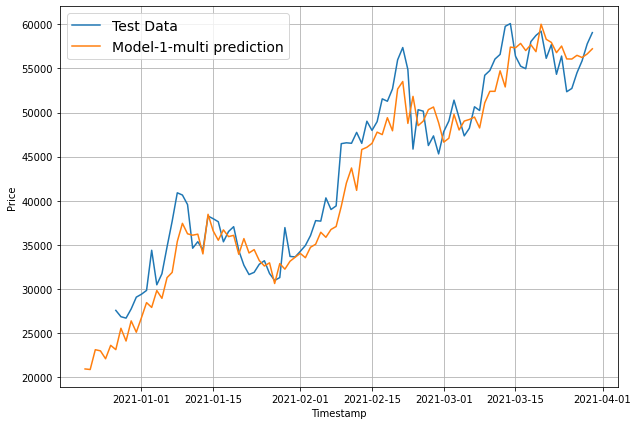

In [63]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=model_1_multi_preds, format="-", start=offset, label="Model-1-multi prediction")

In [49]:
model_1_multi_results = evaluate_preds(y_true=y_test, y_pred=model_1_multi_preds)
model_1_multi_results

{'mae': 1006.6785, 'mape': 4.208973, 'mse': 2745920.5, 'rmse': 1657.0819}

## Model_CONV1D_Multivariate

In [50]:
tf.random.set_seed(42)

# Create Conv1D model
model_2_multi = tf.keras.Sequential([

  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  
  layers.Conv1D(filters=256, kernel_size=8, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  layers.GlobalAveragePooling1D(),
  layers.Dense(HORIZON, activation="relu")

], name="model_conv1D_multi")

# Compile model
model_2_multi.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_2_multi.fit(x_train, #if faced data cardinality error, do tf.stack(train_windows) or np.array(train_windows)
            y_train, 
            batch_size=BATCH_SIZE, 
            epochs=1000, 
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=[create_model_checkpoint(model_name=model_2_multi.name), early_stopping()]
            )

Epoch 1/1000
1/4 [======>.......................] - ETA: 1s - loss: 44071.9805INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 229ms/step - loss: 36892.1250 - val_loss: 21385.2734
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 10952.2637INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 179ms/step - loss: 5836.1636 - val_loss: 8713.3115
Epoch 3/1000
1/4 [======>.......................] - ETA: 0s - loss: 3186.4292INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 177ms/step - loss: 3174.4844 - val_loss: 8709.9521
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 2925.1487INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 176ms/step - loss: 3172.7913 - val_loss: 8696.1357
Epoch 5/1000
1/4 [======>.......................] - ETA: 0s - loss: 3354.6492INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 180ms/step - loss: 3168.3381 - val_loss: 8673.4375
Epoch 6/1000
1/4 [======>.......................] - ETA: 0s - loss: 3396.6150INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 172ms/step - loss: 3162.2261 - val_loss: 8635.7246
Epoch 7/1000
1/4 [======>.......................] - ETA: 0s - loss: 3250.4768INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 175ms/step - loss: 3150.9285 - val_loss: 8574.8516
Epoch 8/1000
1/4 [======>.......................] - ETA: 0s - loss: 3140.3052INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 180ms/step - loss: 3133.6560 - val_loss: 8471.4775
Epoch 9/1000
1/4 [======>.......................] - ETA: 0s - loss: 3142.5562INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 265ms/step - loss: 3105.8501 - val_loss: 8279.1094
Epoch 10/1000
1/4 [======>.......................] - ETA: 0s - loss: 2962.9246INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 180ms/step - loss: 3062.1841 - val_loss: 8051.8525
Epoch 11/1000
1/4 [======>.......................] - ETA: 0s - loss: 3015.8645INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 184ms/step - loss: 3033.2810 - val_loss: 7876.7515
Epoch 12/1000
1/4 [======>.......................] - ETA: 0s - loss: 2895.9629INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 179ms/step - loss: 2989.6663 - val_loss: 7634.3877
Epoch 13/1000
1/4 [======>.......................] - ETA: 0s - loss: 2814.9385INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 177ms/step - loss: 2892.7629 - val_loss: 7120.2866
Epoch 14/1000
1/4 [======>.......................] - ETA: 0s - loss: 2735.7173INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 180ms/step - loss: 2752.6699 - val_loss: 5724.1113
Epoch 15/1000
1/4 [======>.......................] - ETA: 0s - loss: 2337.3621INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 181ms/step - loss: 2057.4058 - val_loss: 5271.9722
Epoch 16/1000
4/4 [==============================] - 0s 11ms/step - loss: 2415.9131 - val_loss: 6351.0874
Epoch 17/1000
4/4 [==============================] - 0s 13ms/step - loss: 2645.5806 - val_loss: 6609.5562
Epoch 18/1000
4/4 [==============================] - 0s 12ms/step - loss: 2690.0195 - val_loss: 6601.7021
Epoch 19/1000
4/4 [==============================] - 0s 11ms/step - loss: 2678.7507 - val_loss: 6478.4829
Epoch 20/1000
4/4 [==============================] - 0s 10ms/step - loss: 2641.2820 - val_loss: 6304.6841
Epoch 21/1000
4/4 [==============================] - 0s 11ms/step - loss: 2579.4500 - val_loss: 5963.7935
Epoch 22/1000
4/4 [==============================] - 0s 9ms/step - loss: 2445.2385 - val_loss: 5398.8945
Epoch 23/1000
1/4 [======>.......................] - ETA: 0s - loss: 2332.0830INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 183ms/step - loss: 2144.5073 - val_loss: 4632.3276
Epoch 24/1000
4/4 [==============================] - 0s 10ms/step - loss: 1984.0836 - val_loss: 4903.8208
Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 2327.5859 - val_loss: 5860.0635
Epoch 26/1000
4/4 [==============================] - 0s 10ms/step - loss: 2497.9089 - val_loss: 5465.0391
Epoch 27/1000
1/4 [======>.......................] - ETA: 0s - loss: 2422.1509INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 176ms/step - loss: 2302.4128 - val_loss: 3774.3040
Epoch 28/1000
4/4 [==============================] - 0s 10ms/step - loss: 1764.8145 - val_loss: 4673.8481
Epoch 29/1000
1/4 [======>.......................] - ETA: 0s - loss: 1791.8525INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


INFO:tensorflow:Assets written to: models/model_conv1D_multi/assets


4/4 [==============================] - 1s 181ms/step - loss: 1477.4435 - val_loss: 1326.5745
Epoch 30/1000
4/4 [==============================] - 0s 10ms/step - loss: 2481.8303 - val_loss: 5333.9609
Epoch 31/1000
4/4 [==============================] - 0s 9ms/step - loss: 2540.0510 - val_loss: 7003.4189
Epoch 32/1000
4/4 [==============================] - 0s 9ms/step - loss: 2792.1885 - val_loss: 6854.3555
Epoch 33/1000
4/4 [==============================] - 0s 9ms/step - loss: 2713.7642 - val_loss: 6075.0137
Epoch 34/1000
4/4 [==============================] - 0s 9ms/step - loss: 2490.3799 - val_loss: 5128.8716
Epoch 35/1000
4/4 [==============================] - 0s 10ms/step - loss: 2202.2683 - val_loss: 4207.3369
Epoch 36/1000
4/4 [==============================] - 0s 10ms/step - loss: 1687.4310 - val_loss: 3895.6880
Epoch 37/1000
4/4 [==============================] - 0s 9ms/step - loss: 1446.9153 - val_loss: 2552.5425
Epoch 38/1000
4/4 [==============================] - 0s 9ms/step

In [51]:
model_2_multi = tf.keras.models.load_model("models/model_conv1D_multi")
model_2_multi.evaluate(x_test, y_test)

11/11 [==============================] - 0s 4ms/step - loss: 2438.9148


2438.914794921875

In [52]:
# Model predictions
model_2_multi_preds = make_prediction(model_2_multi, x_test)

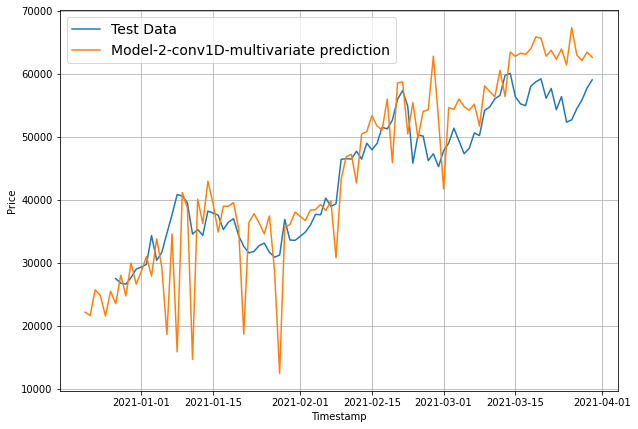

In [53]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=model_2_multi_preds, format="-", start=offset, label="Model-2-conv1D-multivariate prediction")

In [54]:
# Evaluate predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_2_multi_preds)
model_2_results

{'mae': 2438.9148, 'mape': 12.282925, 'mse': 15021800.0, 'rmse': 3875.7966}

## LSTM Multivariate Model

In [55]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=x_train.shape[1])
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.Bidirectional(layers.LSTM(128, activation="relu"))(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_3_multi = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm_multi")

# Compile
model_3_multi.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3_multi.fit(x_train,
            y_train,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(x_val, y_val),
            callbacks=[create_model_checkpoint(model_name=model_3_multi.name), early_stopping()]
            )



Epoch 1/1000
1/4 [======>.......................] - ETA: 6s - loss: 2868.6040INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 7s 1s/step - loss: 4529.4863 - val_loss: 11977.6777
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 5608.8418INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 5179.3447 - val_loss: 6361.9424
Epoch 3/1000
1/4 [======>.......................] - ETA: 0s - loss: 2130.0825INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 2431.0398 - val_loss: 5550.3843
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 1815.9562INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 5s 1s/step - loss: 1688.2921 - val_loss: 4487.2148
Epoch 5/1000
4/4 [==============================] - 0s 18ms/step - loss: 1414.7744 - val_loss: 4736.6772
Epoch 6/1000
1/4 [======>.......................] - ETA: 0s - loss: 2251.1465INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 1673.0389 - val_loss: 3713.0427
Epoch 7/1000
4/4 [==============================] - 0s 18ms/step - loss: 1358.0220 - val_loss: 5509.6909
Epoch 8/1000
4/4 [==============================] - 0s 21ms/step - loss: 1796.3082 - val_loss: 4443.1128
Epoch 9/1000
4/4 [==============================] - 0s 15ms/step - loss: 2008.7731 - val_loss: 5316.1621
Epoch 10/1000
1/4 [======>.......................] - ETA: 0s - loss: 2900.3154INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 3738.0227 - val_loss: 3414.0645
Epoch 11/1000
4/4 [==============================] - 0s 16ms/step - loss: 1728.9033 - val_loss: 5038.9160
Epoch 12/1000
4/4 [==============================] - 0s 16ms/step - loss: 1564.9919 - val_loss: 5486.0840
Epoch 13/1000
1/4 [======>.......................] - ETA: 0s - loss: 3176.1614INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 5s 2s/step - loss: 3278.1794 - val_loss: 2639.7961
Epoch 14/1000
1/4 [======>.......................] - ETA: 0s - loss: 1085.7469INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 1967.2968 - val_loss: 2129.3342
Epoch 15/1000
4/4 [==============================] - 0s 15ms/step - loss: 1214.1866 - val_loss: 2278.1357
Epoch 16/1000
4/4 [==============================] - 0s 15ms/step - loss: 1196.5134 - val_loss: 3208.8398
Epoch 17/1000
1/4 [======>.......................] - ETA: 0s - loss: 1562.0369INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 5s 2s/step - loss: 1714.1407 - val_loss: 2092.9675
Epoch 18/1000
1/4 [======>.......................] - ETA: 0s - loss: 980.9684INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 1009.4000 - val_loss: 1985.5042
Epoch 19/1000
4/4 [==============================] - 0s 15ms/step - loss: 810.3458 - val_loss: 2421.0051
Epoch 20/1000
4/4 [==============================] - 0s 16ms/step - loss: 953.2903 - val_loss: 2955.9106
Epoch 21/1000
4/4 [==============================] - 0s 14ms/step - loss: 968.7694 - val_loss: 2240.9380
Epoch 22/1000
1/4 [======>.......................] - ETA: 0s - loss: 1050.4086INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 7s 2s/step - loss: 864.4388 - val_loss: 1525.9181
Epoch 23/1000
4/4 [==============================] - 0s 32ms/step - loss: 1162.1151 - val_loss: 2482.6313
Epoch 24/1000
4/4 [==============================] - 0s 26ms/step - loss: 1386.0521 - val_loss: 2378.9963
Epoch 25/1000
4/4 [==============================] - 0s 32ms/step - loss: 1366.7357 - val_loss: 2127.2737
Epoch 26/1000
4/4 [==============================] - 0s 35ms/step - loss: 856.1796 - val_loss: 3269.8137
Epoch 27/1000
4/4 [==============================] - 0s 49ms/step - loss: 1126.2520 - val_loss: 4375.3433
Epoch 28/1000
4/4 [==============================] - 0s 25ms/step - loss: 1952.4976 - val_loss: 3072.8625
Epoch 29/1000
4/4 [==============================] - 0s 21ms/step - loss: 1932.0338 - val_loss: 2544.2249
Epoch 30/1000
4/4 [==============================] - 0s 64ms/step - loss: 2299.0027 - val_loss: 3561.8850
Epoch 31/1000
4/4 [==============================] - 0s 40ms/ste

INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 5s 2s/step - loss: 878.9987 - val_loss: 913.4656
Epoch 34/1000
4/4 [==============================] - 0s 15ms/step - loss: 478.7905 - val_loss: 929.0237
Epoch 35/1000
4/4 [==============================] - 0s 15ms/step - loss: 337.6022 - val_loss: 1577.8375
Epoch 36/1000
4/4 [==============================] - 0s 15ms/step - loss: 598.5446 - val_loss: 2535.5693
Epoch 37/1000
4/4 [==============================] - 0s 20ms/step - loss: 859.0247 - val_loss: 1889.7261
Epoch 38/1000
4/4 [==============================] - 0s 23ms/step - loss: 724.0966 - val_loss: 1735.6759
Epoch 39/1000
4/4 [==============================] - 0s 25ms/step - loss: 520.4045 - val_loss: 1289.9880
Epoch 40/1000
4/4 [==============================] - ETA: 0s - loss: 684.1042INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 7s 2s/step - loss: 684.1042 - val_loss: 855.4771
Epoch 41/1000
1/4 [======>.......................] - ETA: 0s - loss: 372.5596INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 5s 2s/step - loss: 452.1675 - val_loss: 488.8212
Epoch 42/1000
4/4 [==============================] - 0s 22ms/step - loss: 257.7048 - val_loss: 1041.8455
Epoch 43/1000
4/4 [==============================] - 0s 38ms/step - loss: 362.7446 - val_loss: 1316.0815
Epoch 44/1000
4/4 [==============================] - 0s 41ms/step - loss: 501.6019 - val_loss: 840.7852
Epoch 45/1000
4/4 [==============================] - 0s 37ms/step - loss: 750.8894 - val_loss: 764.1462
Epoch 46/1000
4/4 [==============================] - 0s 28ms/step - loss: 916.4821 - val_loss: 1150.5900
Epoch 47/1000
4/4 [==============================] - 0s 33ms/step - loss: 895.2776 - val_loss: 730.1218
Epoch 48/1000
4/4 [==============================] - 0s 46ms/step - loss: 1084.8998 - val_loss: 1961.0013
Epoch 49/1000
4/4 [==============================] - 0s 42ms/step - loss: 651.2800 - val_loss: 491.8752
Epoch 50/1000
4/4 [==============================] - 0s 22ms/step - loss: 4

INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 7s 2s/step - loss: 1670.8362 - val_loss: 447.6185
Epoch 58/1000
4/4 [==============================] - 0s 21ms/step - loss: 986.3433 - val_loss: 1073.8560
Epoch 59/1000
4/4 [==============================] - 0s 17ms/step - loss: 873.3256 - val_loss: 1877.5825
Epoch 60/1000
1/4 [======>.......................] - ETA: 0s - loss: 1007.1634INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 5s 2s/step - loss: 605.5591 - val_loss: 433.5727
Epoch 61/1000
4/4 [==============================] - 0s 15ms/step - loss: 553.3885 - val_loss: 1005.2070
Epoch 62/1000
4/4 [==============================] - 0s 17ms/step - loss: 394.5183 - val_loss: 651.1603
Epoch 63/1000
4/4 [==============================] - 0s 14ms/step - loss: 505.9504 - val_loss: 1845.9446
Epoch 64/1000
4/4 [==============================] - 0s 16ms/step - loss: 1094.7174 - val_loss: 1774.9933
Epoch 65/1000
4/4 [==============================] - 0s 15ms/step - loss: 978.3024 - val_loss: 924.6085
Epoch 66/1000
4/4 [==============================] - 0s 16ms/step - loss: 392.6264 - val_loss: 1173.2958
Epoch 67/1000
4/4 [==============================] - 0s 14ms/step - loss: 689.6511 - val_loss: 2023.5211
Epoch 68/1000
4/4 [==============================] - 0s 14ms/step - loss: 849.9657 - val_loss: 2043.4557
Epoch 69/1000
4/4 [==============================] - 0s 15ms/step - loss:

INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 435.4957 - val_loss: 371.0258
Epoch 84/1000
4/4 [==============================] - 0s 16ms/step - loss: 270.5594 - val_loss: 1860.6793
Epoch 85/1000
4/4 [==============================] - 0s 15ms/step - loss: 660.7503 - val_loss: 1239.3572
Epoch 86/1000
4/4 [==============================] - 0s 16ms/step - loss: 448.3549 - val_loss: 376.5845
Epoch 87/1000
4/4 [==============================] - 0s 14ms/step - loss: 166.0439 - val_loss: 647.1119
Epoch 88/1000
4/4 [==============================] - 0s 15ms/step - loss: 331.4604 - val_loss: 635.3721
Epoch 89/1000
4/4 [==============================] - 0s 15ms/step - loss: 304.6950 - val_loss: 681.2859
Epoch 90/1000
1/4 [======>.......................] - ETA: 0s - loss: 358.7999INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 5s 2s/step - loss: 285.5378 - val_loss: 345.1914
Epoch 91/1000
4/4 [==============================] - 0s 15ms/step - loss: 182.8548 - val_loss: 596.1575
Epoch 92/1000
4/4 [==============================] - 0s 16ms/step - loss: 256.6458 - val_loss: 370.0836
Epoch 93/1000
4/4 [==============================] - 0s 14ms/step - loss: 355.7997 - val_loss: 1470.4465
Epoch 94/1000
4/4 [==============================] - 0s 16ms/step - loss: 546.9531 - val_loss: 393.0889
Epoch 95/1000
4/4 [==============================] - 0s 15ms/step - loss: 585.1376 - val_loss: 2247.5637
Epoch 96/1000
4/4 [==============================] - 0s 21ms/step - loss: 1620.1654 - val_loss: 1063.3142
Epoch 97/1000
4/4 [==============================] - 0s 14ms/step - loss: 930.0489 - val_loss: 1488.1515
Epoch 98/1000
4/4 [==============================] - 0s 17ms/step - loss: 650.2675 - val_loss: 1693.9937
Epoch 99/1000
4/4 [==============================] - 0s 15ms/step - loss: 

INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 1065.2172 - val_loss: 326.8764
Epoch 115/1000
4/4 [==============================] - 0s 15ms/step - loss: 546.6393 - val_loss: 1345.7195
Epoch 116/1000
4/4 [==============================] - 0s 16ms/step - loss: 737.3591 - val_loss: 1292.3591
Epoch 117/1000
4/4 [==============================] - 0s 14ms/step - loss: 474.7088 - val_loss: 1848.0043
Epoch 118/1000
4/4 [==============================] - 0s 17ms/step - loss: 554.9268 - val_loss: 528.6464
Epoch 119/1000
4/4 [==============================] - 0s 16ms/step - loss: 430.6241 - val_loss: 811.8534
Epoch 120/1000
4/4 [==============================] - 0s 16ms/step - loss: 350.9203 - val_loss: 1245.3625
Epoch 121/1000
4/4 [==============================] - 0s 14ms/step - loss: 399.9885 - val_loss: 446.0163
Epoch 122/1000
4/4 [==============================] - 0s 14ms/step - loss: 188.5014 - val_loss: 569.3323
Epoch 123/1000
4/4 [==============================] - 0s 14ms/step 

INFO:tensorflow:Assets written to: models/model_lstm_multi/assets


4/4 [==============================] - 4s 1s/step - loss: 214.3114 - val_loss: 307.2808
Epoch 135/1000
4/4 [==============================] - 0s 17ms/step - loss: 245.2889 - val_loss: 778.7956
Epoch 136/1000
4/4 [==============================] - 0s 14ms/step - loss: 335.5235 - val_loss: 647.6013
Epoch 137/1000
4/4 [==============================] - 0s 16ms/step - loss: 277.6288 - val_loss: 432.8982
Epoch 138/1000
4/4 [==============================] - 0s 14ms/step - loss: 411.6747 - val_loss: 1323.5358
Epoch 139/1000
4/4 [==============================] - 0s 14ms/step - loss: 605.8640 - val_loss: 1801.4344
Epoch 140/1000
4/4 [==============================] - 0s 15ms/step - loss: 707.6815 - val_loss: 2121.6138
Epoch 141/1000
4/4 [==============================] - 0s 15ms/step - loss: 732.9773 - val_loss: 2776.1863
Epoch 142/1000
4/4 [==============================] - 0s 16ms/step - loss: 1249.9042 - val_loss: 1621.3490
Epoch 143/1000
4/4 [==============================] - 0s 14ms/step

In [56]:
model_3_multi = tf.keras.models.load_model("models/model_lstm_multi")
model_3_multi.evaluate(x_test, y_test)

11/11 [==============================] - 1s 3ms/step - loss: 818.8691


818.869140625

In [57]:
# Make predictions with our LSTM model
model_3_multi_preds = make_prediction(model_3_multi, x_test)

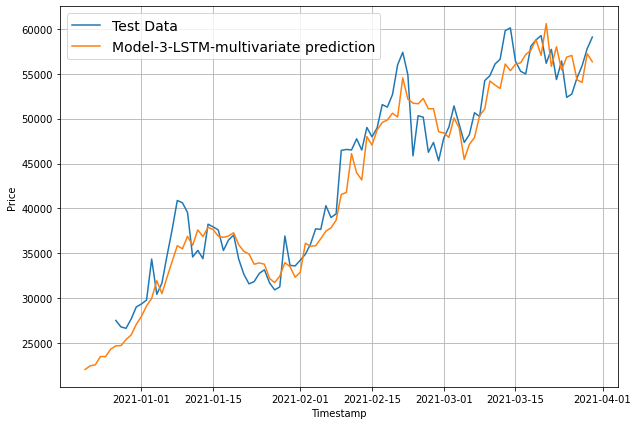

In [58]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=model_3_multi_preds, format="-", start=offset, label="Model-3-LSTM-multivariate prediction")

In [59]:
model_3_results_multi = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_3_multi_preds)
model_3_results_multi

{'mae': 818.8692, 'mape': 3.2820106, 'mse': 1942826.8, 'rmse': 1393.8531}

In [61]:
# Testing with random
model_3_multi.predict(tf.expand_dims([1,2,3,4,5,6,7,8,9,10,12,12], axis=0))

array([[4.990819]], dtype=float32)